# Project Information
- **Name**: homework_1d_classifier.ipynb
- **Version**: 0.1.0
- **Description**: This assignment will show how to train a very simple model to discriminate between two classes in 1-dimensional space
- **Authors**: Nasrin Sultana Nipa <nasrin.sultanan@smail.astate.edu>
- **Professor**: Dr. Jason Causey
- **README File**: [README.md](README.md)

# Dependencies
- **Python**: 3.12
- **numpy**: 1.26.3
- **matplotlib**: 3.8.2
- **ipykernel**: 6.29.0

# Build System
- **Requires**: poetry-core
- **Build Backend**: poetry.core.masonry.api

# Learning a 1-D Classification Model

In this example notebook, we will see how to train a very simple (1 parameter) model to discriminate between two classes in 1-dimensional space.

To run this notebook, we need a way of running Jupyter Notebooks, plus the following packages:

* `numpy`
* `matplotlib`

If you are using Visual Studio Code, you can install all necessary dependencies with Python Poetry using the following command:

```bash
poetry init -q
poetry add numpy matplotlib ipykernel
```

If you do not use Visual Studio Code, you can use JupyterLab.  Prepare the project directory and launch JupyterLab this way:

```bash
poetry init -q
poetry add numpy matplotlib jupyterlab
poetry run jupyter lab
```

Most Python project start by importing libraries. 
Here, we use,
import `numpy` (and nickname it `np`) and the ploting library from `matplotlib` (and nickname it `plt`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now we need to generate some simulated data.  In this example, there will be two classes, and they will be perfectly separable.

In [3]:
np.random.seed(0)  # Make the simulation of datasets repeatable
X = (
    np.concatenate([np.random.normal(-10, 4.5, 50), np.random.normal(10, 4, 50)])
    + 8 * np.random.random()
)
y = np.concatenate([np.zeros(50), np.ones(50)])
# Shuffle the two arrays, but maintain the parallel relationship (labels must match samples).
p = np.random.permutation(len(X))
X = X[p]
y = y[p]
# Now take half to be the training set and half to be the testing set.
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

We now have 50 samples for training, and 50 samples for testing.  

There are 2 classes, and we can show that they are perfectly separable by plotting the full dataset with color and +/- markers to indicate class:

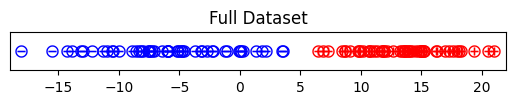

In [4]:
# Plot the dataset as a 1-D scatterplot with blue (-) for the 
# negative class and red (+) for the positive class.
plt.figure().set_figheight(0.5)
plt.scatter(
    X[y == 0],
    np.zeros(sum(y == 0)),
    c="blue",
    marker="$\\ominus$",
    s=80,
    linewidths=0.01,
)
plt.scatter(
    X[y == 1], np.zeros(sum(y == 1)), c="red", marker="$\\oplus$", s=80, linewidths=0.01
)
plt.xlim(-19, 22)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("Full Dataset")
plt.show()

## Our Model

Our model is a simple classifier with a single parameter, which forms a point discriminant in 1-D space to the left of which we will label points as "-" and to the right of which we will label points as "+".  

The model is:

$$g(x|t) = 1(t < x)$$

We have only one "free" parameter to learn: $t$, which acts as a "threshold" to determine the class.
$t$ could take on any value from $-\infty$ to $\infty$.

In practice though, there is no reason to look at any value less than the smallest $x$ value (minus a small "epsilon" in case all examples are positive), or larger than the largest $x$ value.  So the true range of possible values for $t$ is $[\min(X)-\epsilon,\ \max(X)]$.

We need a way to know when our choice of $t$ is a good one.  We will target the metric **_accuracy_**, defined as:
$$\textrm{accuracy} = \frac{\textrm{Correct}}{\textrm{Total}}$$ 
where "Correct" means we correctly classify the data point.  "Total" is the total number of predictions we make with the model.  Since accuracy is a metric in which a higher value is better, we want to _maximize_ the result.

Algorithmically, we will "learn" the correct setting for $t$ by starting at the lowest feasible value and "sweeping" it slowly toward larger values, recording the best accuracy (and corresponding $t$ that produced it) along the way.  This is a brute-force approach, and we can probably make it more efficient... But it is a very intuitive algorithm to implement, so let's try it.

```text
let g := threshold discriminant function
let X := training set x variables
let y := training set y (ground truth) labels
let epsilon := 5.1
let t := min(X) - epsilon
let best_acc := 0
let best_t   := t
while t <= max(X), do:
    let current_acc = evaluate(g,t,X,y)
    if current_acc > best_acc:
        best_acc = current_acc
        best_t   = t
    t = t + epsilon
```
And, we need to define what the `evaluate()` function will do, which is to compute $\hat{y} = g(x^i|t)\  \forall \ x^i\in X$, where $\hat{y}$ is our list of _predictions_.  Now, we compute the accuracy, according to the formula above, and that number is returned.

```text
define function evaluate(g,t,X,y):
    let y_pred := empty list
    for each x in X:
        add g(x,t) to y_pred
    let correct_preds := list of size |y|, all zeros
    for i in [0, |y|):
        if y[i] == y_pred[i]:
            correct_preds[i] = 1
    let acc := sum(correct_preds) / |y|
    return acc
```

In Python, we need to define the function dependencies first, before the main routine.  So we start with `g()` and  `evaluate()`:

In [19]:
# Our classifier function, parameterized on threshold `t`
def g(x, t):
    return t < x

# Get the accuracy of classifer `g` given threshold `t` on samples
# `X` whose correct class is given by `y`
def evaluate(g, t, X, y):
    y_pred = []
    for x in X:
        y_pred.append(g(x, t))
    correct_preds = []
    for i in range(len(y)):
        correct_preds.append(y[i] == y_pred[i])
    acc = sum(correct_preds) / len(y)
    return acc

Now we can define the routine for learning a possible value for $t$.

In [20]:
# Train the classifier `g` on the training data `X_train` supervised by
# the ground truth classes `y_train`
def train(g, X_train, y_train):
    epsilon = 0.25
    t = min(X_train) - epsilon
    best_acc = 0
    best_t = t
    while t <= max(X_train):
        current_acc = evaluate(g, t, X_train, y_train)
        if current_acc > best_acc:
            best_acc = current_acc
            best_t = t
        # Let's print any accuracies that are "almost" perfect...
        if current_acc > 0.975:
            print(f"t={t:0.1f}, acc={current_acc:0.2f}")
        t = t + epsilon
    return best_t

# Perform the training and report the final accuracy on the training set:
t = train(g, X_train, y_train)
print(f"\nWe found the best threshold `t` at {t:0.3f}\n")

t=1.5, acc=0.98
t=1.7, acc=0.98
t=2.0, acc=1.00
t=2.2, acc=1.00
t=2.5, acc=1.00
t=2.7, acc=1.00
t=3.0, acc=1.00
t=3.2, acc=1.00
t=3.5, acc=1.00
t=3.7, acc=1.00
t=4.0, acc=1.00
t=4.2, acc=1.00
t=4.5, acc=1.00
t=4.7, acc=1.00
t=5.0, acc=1.00
t=5.2, acc=1.00
t=5.5, acc=1.00
t=5.7, acc=1.00
t=6.0, acc=1.00
t=6.2, acc=1.00
t=6.5, acc=1.00
t=6.7, acc=1.00
t=7.0, acc=1.00
t=7.2, acc=1.00
t=7.5, acc=0.98
t=7.7, acc=0.98
t=8.0, acc=0.98
t=8.2, acc=0.98

We found the best threshold `t` at 1.977



But... _Is_ that the "best" threshold $t$?  (This was the accuracy on the _training_ set, after all.  It should be perfect!)

Evaluating the model solely on the training set can give an overly optimistic view of its performance since the model might have simply memorized the training data without truly learning to generalize.

By evaluating the model on the testing set using the best threshold `t`, we're assessing its ability to generalize to unseen data, which is crucial for assessing its real-world performance. This approach ensures that the model's performance estimation is more reliable and indicative of its true effectiveness.

The following code snippet for evaluating the model using the `evaluate` function with the best threshold `t` and the testing data `X_test` and `y_test`, then printing the test accuracy. This step provides valuable insight into how well our model performs on new, unseen data.

Let's try running an evaluation of our model with our "best" $t$ against the _testing_ set:

In [21]:
test_accuracy = evaluate(g, t, X_test, y_test)
print(f"The test accuracy is: {test_accuracy:0.2f} ({test_accuracy*100}%)")

The test accuracy is: 0.94 (94.0%)


OK... Why didn't this give perfect performance? We know the dataset _is_ separable... We've seen it!

The fact that the dataset is separable doesn't guarantee perfect performance on unseen data. Several factors could contribute to the discrepancy between the training accuracy and the test accuracy:

1. **Overfitting:** The model may have overfit to the training data, capturing noise or outliers that don't generalize well to new data. This can lead to a drop in performance when evaluated on the testing set.

2. **Dataset Distribution:** While the dataset is separable, the testing set might have slightly different distribution characteristics compared to the training set. This difference can affect the model's ability to generalize, leading to a decrease in performance on the testing set.

3. **Threshold Sensitivity:** The threshold `t` chosen based on the training set might not be optimal for the testing set. Even though the model achieved high accuracy on the training set with the selected threshold, it may not generalize well to unseen data.

4. **Randomness:** The dataset generation process involves randomness, such as the random initialization of data points and shuffling. This randomness can lead to variations in performance between different runs of the experiment.

To address these issues and improve generalization performance, you can consider techniques such as cross-validation, regularization, or using more sophisticated models. Additionally, analyzing misclassified instances in the testing set can provide insights into the model's weaknesses and areas for improvement.

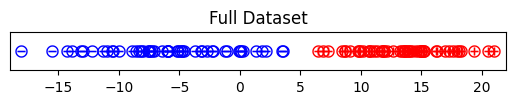

In [22]:
# Plot the dataset as a 1-D scatterplot with blue (-) for the 
# negative class and red (+) for the positive class.
plt.figure().set_figheight(0.5)
plt.scatter(
    X[y == 0],
    np.zeros(sum(y == 0)),
    c="blue",
    marker="$\\ominus$",
    s=80,
    linewidths=0.01,
)
plt.scatter(
    X[y == 1], np.zeros(sum(y == 1)), c="red", marker="$\\oplus$", s=80, linewidths=0.01
)
plt.xlim(-19, 22)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title("Full Dataset")
plt.show()

Let's look at the training and testing sets individually though, and plot the threshold $t$ that we learned as well:

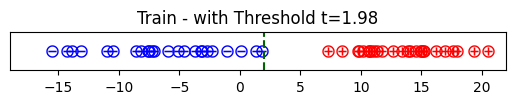

In [23]:
# Plot the training dataset as a 1-D scatterplot with blue (-) for the 
# negative class and red (+) for the positive class. Add a vertical line
# at the threshold `t`.
plt.figure().set_figheight(0.5)
plt.scatter(
    X_train[y_train == 0],
    np.zeros(sum(y_train == 0)),
    c="blue",
    marker="$\\ominus$",
    s=80,
    linewidths=0.01,
)
plt.scatter(
    X_train[y_train == 1],
    np.zeros(sum(y_train == 1)),
    c="red",
    marker="$\\oplus$",
    s=80,
    linewidths=0.01,
)
plt.axvline(x=t, c="darkgreen", linestyle="dashed")
plt.xlim(-19, 22)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title(f"Train - with Threshold t={t:0.2f}")
plt.show()

And the same for the testing set:

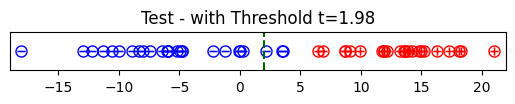

In [24]:
# Plot the testing dataset as a 1-D scatterplot with blue (-) for the 
# negative class and red (+) for the positive class. Add a vertical line
# at the threshold `t`.
plt.figure().set_figheight(0.5)
plt.scatter(
    X_test[y_test == 0],
    np.zeros(sum(y_test == 0)),
    c="blue",
    marker="$\\ominus$",
    s=80,
    linewidths=0.01,
)
plt.scatter(
    X_test[y_test == 1],
    np.zeros(sum(y_test == 1)),
    c="red",
    marker="$\\oplus$",
    s=80,
    linewidths=0.01,
)
plt.axvline(x=t, c="darkgreen", linestyle="dashed")
plt.xlim(-19, 22)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title(f"Test - with Threshold t={t:0.2f}")
plt.show()

Now we can clearly see that the learned threshold $t$ separates the training set, but it fails to separate the testing set. 

We would say that this model _fails to generalize_.

**Could we do better?**   

**If so, how?**   ...  

Yes, by determining an optimal threshold (`t`) for classification based on the distribution of the training data. Here's a breakdown of what we've done:

1. **Finding Index of Last Blue and First Red Points**: We've identified the indices of the point after last blue point and the first red point in the training dataset. This step involves locating the boundaries between the two classes.

2. **Calculating the Midpoint**: Once we've identified the indices, we've calculated the midpoint between the last blue point and the first red point. This midpoint serves as a potential threshold value (`t`) for classifying new data points.

3. **Visualizing the Threshold**: We've plotted the training dataset along with the threshold (`t`) and vertical lines at the endpoints of the blue and red points. This visualization helps visualize how the threshold separates the two classes.

This process can be considered a form of threshold determination or threshold optimization, where we're trying to find a threshold value that effectively separates the classes in the training data. It's a crucial step in building classification models, especially when dealing with binary classification problems.

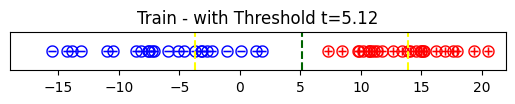

In [43]:
# Find the index of the last blue point and the first red point
last_blue_index = np.where(y_train == 0)[0][-2]
first_red_index = np.where(y_train == 1)[0][0]

# Calculate the midpoint between these two points
t = (X_train[last_blue_index] + X_train[first_red_index]) / 2

# Plot the training dataset as a 1-D scatterplot with blue (-) for the 
# negative class and red (+) for the positive class. Add a vertical line
# at the threshold `t`, and vertical lines at the endpoints of the blue and red points.
plt.figure().set_figheight(0.5)
plt.scatter(
    X_train[y_train == 0],
    np.zeros(sum(y_train == 0)),
    c="blue",
    marker="$\\ominus$",
    s=80,
    linewidths=0.01,
)
plt.scatter(
    X_train[y_train == 1],
    np.zeros(sum(y_train == 1)),
    c="red",
    marker="$\\oplus$",
    s=80,
    linewidths=0.01,
)

# Plot vertical lines at the endpoints of the blue and red points
plt.axvline(x=X_train[last_blue_index], c="yellow", linestyle="dashed")
plt.axvline(x=X_train[first_red_index], c="yellow", linestyle="dashed")

plt.axvline(x=t, c="darkgreen", linestyle="dashed")  # Threshold line
plt.xlim(-19, 22)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title(f"Train - with Threshold t={t:0.2f}")
plt.show()


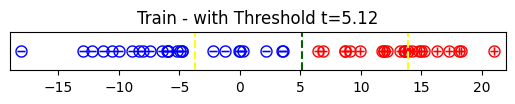

In [45]:
# Plot the testing dataset as a 1-D scatterplot with blue (-) for the 
# negative class and red (+) for the positive class. Add a vertical line
# at the threshold `t`.
plt.figure().set_figheight(0.5)
plt.scatter(
    X_test[y_test == 0],
    np.zeros(sum(y_test == 0)),
    c="blue",
    marker="$\\ominus$",
    s=80,
    linewidths=0.01,
)
plt.scatter(
    X_test[y_test == 1],
    np.zeros(sum(y_test == 1)),
    c="red",
    marker="$\\oplus$",
    s=80,
    linewidths=0.01,
)
# Plot vertical lines at the endpoints of the blue and red points
plt.axvline(x=X_train[last_blue_index], c="yellow", linestyle="dashed")
plt.axvline(x=X_train[first_red_index], c="yellow", linestyle="dashed")

plt.axvline(x=t, c="darkgreen", linestyle="dashed")  # Threshold line
plt.xlim(-19, 22)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title(f"Train - with Threshold t={t:0.2f}")
plt.show()